# Projeto final - Álgebra Linear
# Reconhecimento de Imagens com Análise Discriminante Linear (LDA) - Fisherfaces

### Nome: Luis Henrique Ponciano dos Santos NUSP: 15577760
### Nome: Gabriel Araujo Lima NUSP: 14571376 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
import seaborn as sns  

Utilizamos o LDA (Linear Discriminant Analysis) como um método de redução de dimensionalidade supervisionado, empregado aqui como uma etapa de pré-processamento para classificação de padrões com o algoritmo K-Nearest Neighbors (KNN).

Assim como o PCA, o LDA busca projetar os dados em um subespaço de menor dimensão. No entanto, enquanto o PCA visa maximizar a variância total dos dados (sem considerar as classes), o LDA procura encontrar um novo eixo 
𝑊
W que maximiza a separação entre múltiplas classes, mantendo as amostras de uma mesma classe próximas entre si.

O LDA É divido em alguns passos, sendo eles, listados a seguir: \
\
*Step 1* - Calcular as matrizes de dispersão entre as classes(Sb) e dentro das classes(Sw), mais conhecidas como `within-class scatter matrix (Sw)` e `Between class matrix (Sb)` 
sendo que Sw e Sb é dado respectivamente como:

$$S_W = \sum_i \sum_{x \in C_i} (x - \mu_i)(x - \mu_i)^T$$

$$S_B = \sum_i n_i (\mu_i - \mu)(\mu_i - \mu)^T$$

$S_W$ é a soma das matrizes de dispersão (scatter matrices) de cada classe, no LDA queremos que ele seja minima pois indicará classes compactas e densas. \
$S_B$ mede o quão espalhadas as médias das classes ($\mu_i$) estão umas das outras (em relação à média global $\mu$), no LDA quanto maior for, melhor, pois indica que o centro das classes estão distantes entre si. 
\
\
*Step 2* - Encontrar a melhor vetor de projeção LDA\
Semelhante ao que é realizado no PCA, o LDA também utiliza os autovetores e autovalores para encontrar esta projeção resolvendo a equação: $$SW⁻¹​SB​w=λw$$
Desta forma encontramos os maiores autovalores associados aos seus autovetores
\
\
*Step 3* - Reduzindo a dimensão
$$Y = WX$$
Sendo que W é a matriz de projeção formada pelos k autovetores associados aos maiores autovalores, cujo autovalores grandes: Indicam as direções de maior separabilidade entre as classes.\
X é a minha matriz original que será reduzida dimensionalmente

In [2]:
faces = fetch_olivetti_faces() # Carrega conjunto de imagens de rostos humanos em tons de cinza
x_all = faces.data      # imagens vetorizadas, cada linha é uma amostra de imagem contendo 4096 colunas representando os pixels achatado 64x64
y_all = faces.target    # rótulos (pessoa) tem 400 elementos (sendo 10 representaçao por cada pessoa)

# 2) Divisão treino/teste das amostras, para posteriormente termos uma avalição justa
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.25, stratify=y_all, random_state=42
)
# checar shapes
print("x_train:", x_train.shape, "x_test:", x_test.shape)

# Calcula a média global apenas do conjunto do treino, como é calculada ? Soma todos os elementos da coluna e divide pelo quantidade de amostras no conjunto de treino
# um vetor de 4096 posições representando a média de cada dimensao (coluna=pixel)
m_global_train = np.mean(x_train,axis=0) 

# Classes presentes (categorias), total sao 40, pois há 40 pessoas
classes = np.unique(y_train)

# Inicializa as matrizes de dispersao Sw e Sb
d = x_train.shape[1] # dimensao de 4096
s_w = np.zeros((d,d))
s_b = np.zeros((d,d))

# Calcula para cada classe a sua matriz de dispersao e forma a matriz de dispersao entre as classes
for c in classes:
    X_c = x_train[y_train == c] # amostras da classe c no conjunto de treino, retorna uma matriz contendo apenas as imagens da classe c.
    mu_c = np.mean(X_c, axis=0) # Media da classe, vetor 4096 posições.
    
    # Calculo da matriz de dispersao dentro da classe
    # somatório de (x - mu_c)(x - mu_c)^T
    diff = X_c - mu_c
    s_w += diff.T @ diff
    
    #Calculo da matriz de dispersao entre as classes
    n_c = X_c.shape[0] # representa o número de amostras (imagens) da classe (pessoa)
    # somatório de n(x - mu_g)(x - mu_g)^T
    mean_diff = (mu_c - m_global_train).reshape(-1,1) # transforma um vetor 1d em um vetor 2d (4096x1)
    s_b += n_c * (mean_diff @ mean_diff.T)


# Com com as matrizes formadas agora podemos calcular os eigenvalues e eigenvectors
# Para resolver o problema do autovalor generalizado utilizando SW⁻¹​SB​w=λw
eps = 1e-3
s_w_inv = np.linalg.pinv(s_w + eps * np.eye(d)) # Calcula a pseudo-inversa de Sw e regulariza para evitar singularidades
eigenvalues, eigenvectors = np.linalg.eig(s_w_inv @ s_b)

# número máximo de componentes = min(d, number_of_classes_in_train - 1)
k_max = min(d, len(classes) - 1)

k = k_max # k = 39 dimensões ou seja os 39 (componentes) principais

# Ordenando os auto-valores em ordem decrescente
idx = np.argsort(-eigenvalues.real) # retorna uma lista dos indices dos maiores autovalores para os menores
W = eigenvectors[:, idx[:k]].real # matriz W(4096, 39) é a matriz de projeção que possui as informações mais importantes

# normaliza colunas de W para norma 1 (fica mais fácil na hora de visualizar)
W = W / np.linalg.norm(W, axis=0, keepdims=True)

#centralizar X com média do treino e projetar treino/teste
x_train_centered = x_train - m_global_train
x_test_centered  = x_test - m_global_train

x_train_lda = x_train_centered @ W      # (4096, 39) agora temos 300 imagens projetadas em 39 componentes discriminantes ao invés de 4096
x_test_lda  = x_test_centered @ W       # (4096, 39) o mesmo aqui para as 100 imagens

print("x_train_lda shape:", x_train_lda.shape, "X_test_lda shape:", x_test_lda.shape)


x_train: (300, 4096) x_test: (100, 4096)
x_train_lda shape: (300, 39) X_test_lda shape: (100, 39)


Representação das pessoas presentes nas amostras das matrizes de testes e de treino

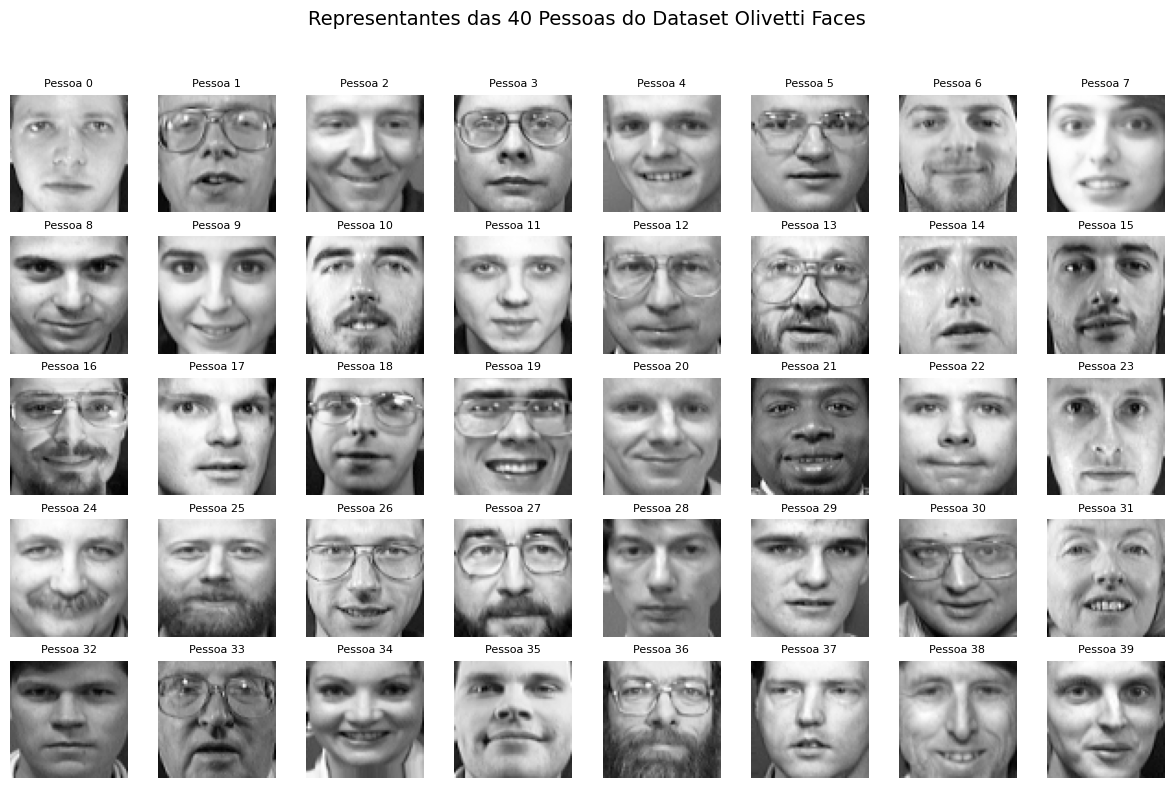

In [9]:
# Criar figura 5x8 = 40 imagens
fig, axes = plt.subplots(5, 8, figsize=(12, 8))
fig.suptitle("Representantes das 40 Pessoas do Dataset Olivetti Faces", fontsize=14)

# Exibir uma imagem (primeira ocorrência) de cada pessoa
for i in range(len(classes)):
    ax = axes[i // 8, i % 8]  # posição na grade 5x8
    img = x_all[y_all == i][0].reshape(64, 64)  # pega a primeira imagem da pessoa i
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pessoa {i}", fontsize=8)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Apos ter clusterizado os nossos dados utilizando LDA, cujo maximiza a separabilidade das classes (tipo de pessoas), aplicamos um modelo simples de classificação K-Nearest Neighbors (KNN).

Acurácia (KNN sobre LDA manual): 0.9900

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2
          16    

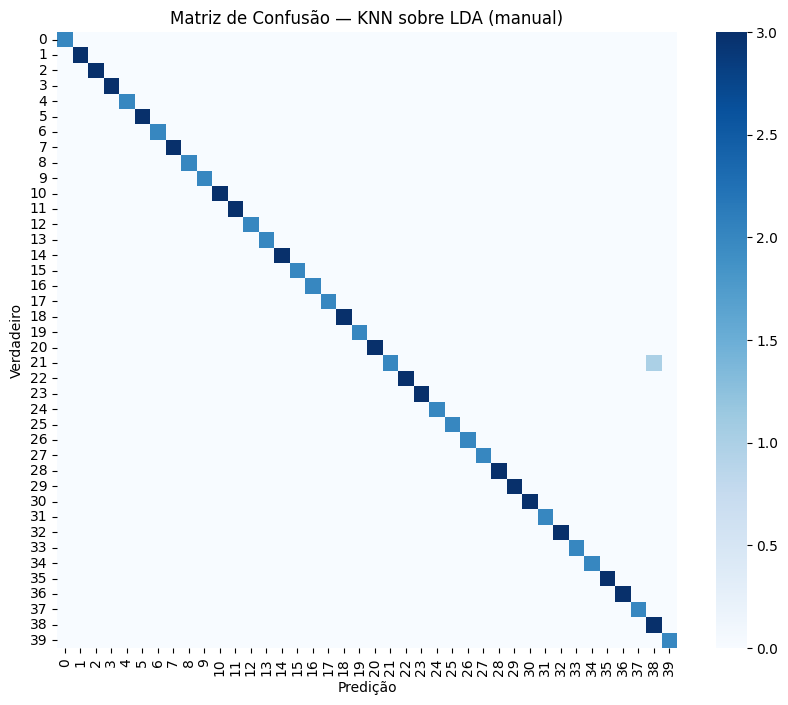

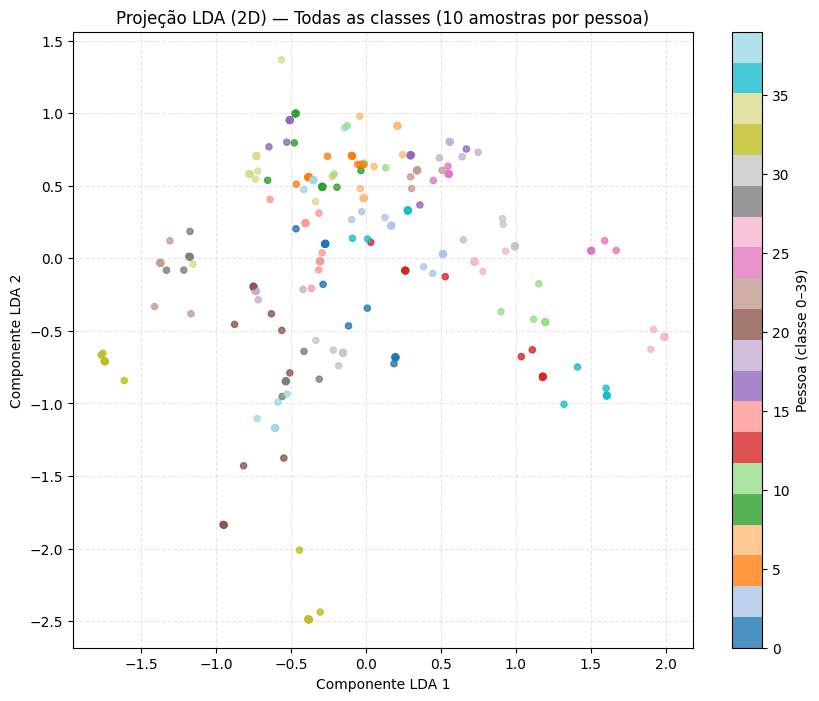

In [ ]:
# Treinar um classificador simples de KNN nas 39 features do LDA, cujo verifica os 5 vizinhos proximos de cada classe
# o KNN apenas confirma que o lda agrupou corretamente cada classe de maneira adequada
# 9) Treinar um classificador simples (KNN) sobre as componentes LDA
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_lda, y_train)
y_pred = knn.predict(x_test_lda)

# 10) Avaliar
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia (KNN sobre LDA manual): {acc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# 11) Plot da matriz de confusão (opcional, útil no relatório)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", annot=False, fmt="d")
plt.title("Matriz de Confusão — KNN sobre LDA (manual)")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.show()

# ---- Projeção total (treino + teste) ----
X_all_centered = np.vstack((x_train_centered, x_test_centered))
y_all_labels = np.hstack((y_train, y_test))

# Projetar para 2D (usando as duas primeiras componentes de W)
X_lda_2D = X_all_centered @ W[:, :2]

# Adicionar pequeno ruído visual para enxergar mais pontos de cada classe
X_lda_2D_vis = X_lda_2D + np.random.normal(0, 0.002, X_lda_2D.shape)

# ---- Plotar ----
plt.figure(figsize=(10,8))
scatter = plt.scatter(
    X_lda_2D_vis[:,0],
    X_lda_2D_vis[:,1],
    c=y_all_labels,
    cmap='tab20',
    s=20,
    alpha=0.8
)
plt.title("Projeção LDA (2D) — Todas as classes (10 amostras por pessoa)")
plt.xlabel("Componente LDA 1")
plt.ylabel("Componente LDA 2")
plt.colorbar(scatter, label="Pessoa (classe 0-39)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

Como podemos observar, a acurácia do classificador foi de 99%, o que indica que o LDA foi capaz de reduzir as 4096 features originais para 39 componentes discriminantes, sem perda significativa de informação relevante.

O gráfico de dispersão mostra uma separação nítida entre as classes, confirmando que o LDA cumpriu seu papel de maximizar a separabilidade entre grupos diferentes e minimizar a variação dentro de cada grupo.

A matriz de confusão apresenta uma diagonal quase perfeita, evidenciando que as predições do modelo coincidiram quase integralmente com os rótulos verdadeiros.